# Alignment tutorial for Multimodal alignment
+ In this tutorial, we will demonstrate how to implement Multimodal alignment using 3d-OT and calculate the chamfer distance.
+ Spatial-epigenome-transcriptome enables joint profiling of the epigenome and transcriptome by cosequencing chromtin accessibility and gene expression. 
+ We collected the data from from AtlasXplore [Raw data](https://web.atlasxomics.com/visualization/Fan).

## Loading package

In [1]:
from lib_3d_OT.utils import *
import scanpy as sc
import numpy as np
import pandas as pd
import torch
from lib_3d_OT.multi_modialty import *
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore")

During startup - Warning messages:
1: package ‘methods’ was built under R version 4.3.2 
2: package ‘datasets’ was built under R version 4.3.2 
3: package ‘utils’ was built under R version 4.3.2 
4: package ‘grDevices’ was built under R version 4.3.2 
5: package ‘graphics’ was built under R version 4.3.2 
6: package ‘stats’ was built under R version 4.3.2 
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



In [2]:
import os
os.environ['R_HOME'] = '/home/dbj/anaconda3/envs/r/lib/R'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## We use multimodal clustering results as annotation information for aligned slices

In [3]:
adataac=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset9_Mouse_Brain_H3K27ac/3d-OT.h5ad')
adataATAC=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset7_Mouse_Brain_ATAC/3d-OT.h5ad')

## Loading data

In [4]:
adata1=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_RNA.h5ad')
adata2=sc.read_h5ad('/home/dbj/mouse/SpatialGlue/Mouse_Brain/adata_peaks_normalized.h5ad')
adata1.obs['truth']=adataATAC.obs['3d-OT'].astype(str) + '_1'
adata2.obs['truth']=adataATAC.obs['3d-OT'].astype(str) + '_1'
adata1.var_names_make_unique()
adata2.var_names_make_unique()

adata3=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset9_Mouse_Brain_H3K27ac/adata_RNA.h5ad')
adata4=sc.read_h5ad('/home/dbj/mouse/spatialglue_alldata/Dataset9_Mouse_Brain_H3K27ac/adata_peaks_normalized.h5ad')
adata3.obs['truth'] = adataac.obs['3d-OT'].astype(str) + '_2'
adata4.obs['truth'] = adataac.obs['3d-OT'].astype(str) + '_2'
adata3.var_names_make_unique()
adata4.var_names_make_unique()

## Pre-processing data
+ 3d-OT adopts standard pre-processing steps for the transcriptomic and chromatin peak data. 
+ Specifically,for the transcriptomics data,the gene expression counts are log-transformed and normalized by library size via the SCANPY package. 
+ The top 3,000 highly variable genes (HVGs) are selected as input of PCA for dimension reduction. 
+ To ensure a consistent input dimension with the chromatin peak data, the first 50 principal components are retained and used as the input of the model. 
+ For the chromatin peak data, we used LSI (latent semantic indexing) to reduce the raw chromatin peak counts data to 50 dimensions.

In [5]:
sc.pp.filter_genes(adata1, min_cells=10)
sc.pp.filter_cells(adata1, min_genes=200)
sc.pp.highly_variable_genes(adata1, flavor="seurat_v3", n_top_genes=3000)
adata1 =  adata1[:, adata1.var['highly_variable']]
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat'] = pca(adata1, n_comps=50)

adata2 = adata2[adata1.obs_names].copy()
if 'X_lsi' not in adata2.obsm.keys():
    sc.pp.highly_variable_genes(adata2, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata2, use_highly_variable=False, n_components=51)
adata2.obsm['feat'] = adata2.obsm['X_lsi'].copy()

sc.pp.filter_genes(adata3, min_cells=10)
sc.pp.filter_cells(adata3, min_genes=200)
adata3.obsm['spatial'] = adata3.obsm['spatial'][:, [1, 0]]
adata3.obsm['spatial'][:, 1] = -adata3.obsm['spatial'][:, 1]
sc.pp.highly_variable_genes(adata3, flavor="seurat_v3", n_top_genes=3000)
adata3 =  adata3[:, adata3.var['highly_variable']]
sc.pp.normalize_total(adata3, target_sum=1e4)
sc.pp.log1p(adata3)
sc.pp.scale(adata3)
adata3.obsm['feat'] = pca(adata3, n_comps=50)

adata4 = adata4[adata3.obs_names].copy()
adata4.obsm['spatial'] = adata3.obsm['spatial']
if 'X_lsi' not in adata4.obsm.keys():
    sc.pp.highly_variable_genes(adata4, flavor="seurat_v3", n_top_genes=3000)
    lsi(adata4, use_highly_variable=False, n_components=51)
adata4.obsm['feat'] = adata4.obsm['X_lsi'].copy()

## Constructing the ATAC+RNA neighbor graph1 and training the PointNet++ Encoder

In [6]:
set_seed(7)
graph1 = prepare_data(adata1, location="spatial", nb_neighbors=16).to(device)
graph2 = prepare_data(adata2, location="spatial", nb_neighbors=16).to(device)
input_dim = graph1.express.shape[-1]
hidden_dim=32
model = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_time = time.time()
best_model1 = train_graph_extractor(graph1,graph2, model ,optimizer, device,epochs=300)

## Constructing the H3K27ac+RNA neighbor graph2 and training the PointNet++ Encoder

In [7]:
graph3 = prepare_data(adata3, location="spatial", nb_neighbors=16).to(device)
graph4 = prepare_data(adata4, location="spatial", nb_neighbors=16).to(device)
input_dim = graph3.express.shape[-1]
hidden_dim=32
model2 = extractModel(input_dim,hidden_dim,n_heads=4, n_layers=3)
model2 = model2.to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
best_model2 = train_graph_extractor(graph3,graph4, model2 ,optimizer2, device,epochs=300)

## Pretrained encoder and graph structure loading into multimodal alignment module

In [8]:
pcloud_list1=[graph1,graph2]
pcloud_list2=[graph3,graph4]
pclouds_list=[pcloud_list1,pcloud_list2]

In [9]:
input_dim = graph1.express.shape[-1]
model = UnifiedModel(input_dim=input_dim,hidden_dim=32,simk=5,otk=200,reconk=1,best_encoder1=best_model1,best_encoder2=best_model2
)


optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_lambda = lambda epoch: 1.0 if epoch < 340 else 1.0
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
args = {
    "backward_dist_weight":1.0,
    "use_smooth_flow":1,
    "smooth_flow_loss_weight":1.0,
    "use_div_flow":1,
    "div_flow_loss_weight":1.0,
    "div_neighbor": 8,
    "lattice_steps": 10,
    "nb_neigh_smooth_flow":32,
}



train(
    model=model,
    pcloud_list=pclouds_list,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    use_smooth_flow=True,
    use_div_flow=True,
    args=args
)

Time Pair 0,total_loss: 0.1169,smooth_flow_loss: 0.0689 Target Recon Loss: 0.0003, Div Flow Loss: 0.0477

In [10]:
from lib_3d_OT.plot import *

## Annotation information of alignment slices and visualization of multimodal alignment results
### Source align slice truth

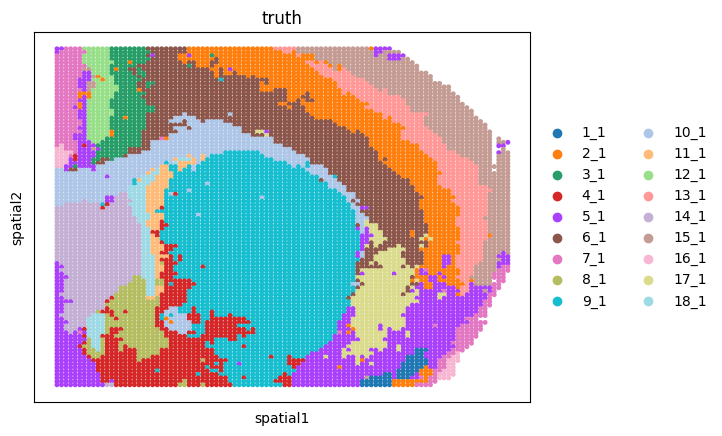

In [13]:
sc.pl.embedding(adata1,basis='spatial',color='truth',size=50)

### Target align slice truth

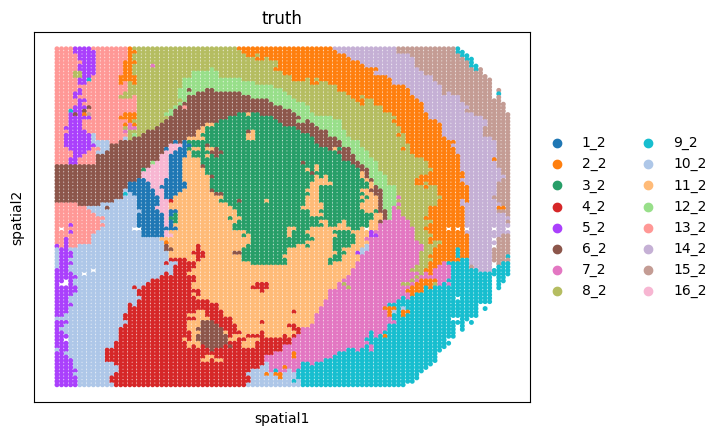

In [15]:
sc.pl.embedding(adata3,basis='spatial',color='truth',size=50)

###  Visualize and quantify the alignment results for multimodal latent representations
+ `selected_cell_type` represents the drawn source cell type.
+ `finaltruth` means that the target cell type corresponding to the source cell type that based on the biological understanding, and it is used to obtain the spatial location information of the target cell type and calculate the chamfer distance.
+ `all_arrow_ends` represents all aligned flow end positions from source cell type,it is used to calculate the chamfer distance.
+ `layer_1_pcloud_3D` represents the target cell type spatial position information based on biological understanding, and is used to calculate the chamfer distance.
+ The 8_2 and 12_2 regions from slice H3K27ac+RNA sections are considered by us as alignment targets from the ATAC+RNA slice 6_1 region.

Number of arrow ends: 1171
Layer 1 points count: 1135


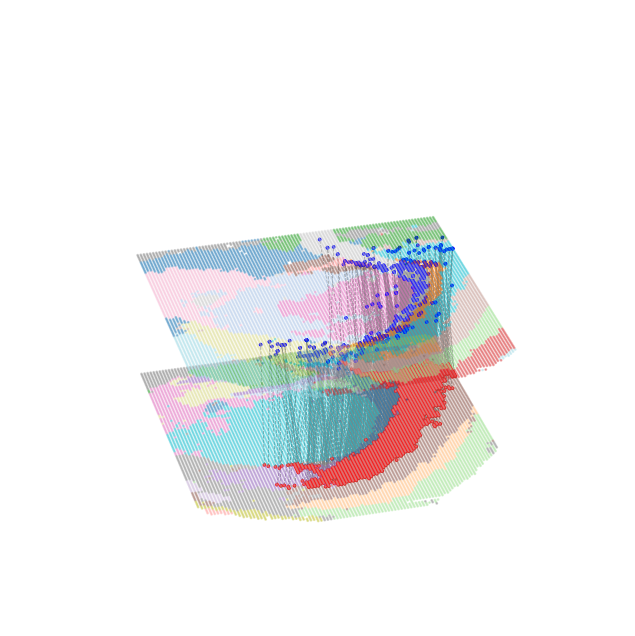

In [11]:
all_arrow_ends,layer_1_pcloud_3D=plot_multi_selected_cell_type_flow(
    pclouds_list, 
    model, 
    device,
    selected_cell_type='6_1',
    finaltruth=['8_2','12_2'],
    xlim=(-0.1, 1.1),
    ylim=(-0.1, 1.1),
    #save_path='/home/dbj/mouse/spatialglue_alldata/multialign/multi-multi.png'
)

`-Log10(chamfer_distance)` as a performance metric for alignment

In [12]:
chamfer_dist = chamfer_distance(all_arrow_ends,layer_1_pcloud_3D)

print(f"chamfer distance: {chamfer_dist}")

chamfer distance: 0.0026237226396173567
